In [1]:
import sys
# sys.path.append('../../NeuralTuringMachine')


import tensorflow as tf
# from ntm import NTMCell


if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

/home/francesco/anaconda3/envs/goseek/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/francesco/anaconda3/envs/goseek/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/francesco/anaconda3/envs/goseek/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/francesco/anaconda3/envs/goseek

Please install GPU version of TF


In [2]:
def conv_to_fc(input_tensor):
    n_hidden = tf.reduce_prod([v.value for v in input_tensor.get_shape()[1:]])
    input_tensor = tf.reshape(input_tensor, [-1, n_hidden])
    return input_tensor

def linear(input_tensor, num_hidden, scope):
    n_input = input_tensor.get_shape()[1].value
    with tf.variable_scope(scope):
        weight = tf.get_variable("w", [n_input, num_hidden], initializer=tf.initializers.orthogonal())
        bias = tf.get_variable("b", [num_hidden], initializer=tf.constant_initializer(0.0))
        return tf.matmul(input_tensor, weight) + bias
    
def linear2d(input_tensor, num_hidden, scope):
    b, h, w = input_tensor.shape
    with tf.variable_scope(scope):
        tensors = []
        for i in range(h):
            weight = tf.get_variable("w"+str(i), [w, num_hidden], initializer=tf.initializers.orthogonal())
            bias = tf.get_variable("b"+str(i), [num_hidden], initializer=tf.constant_initializer(0.0))
            tensors.append(tf.matmul(input_tensor[:,i,:], weight) + bias)
        return tf.stack(tensors, axis=1)
    
    
def conv2d(input_tensor, num_filters, filter_size, stride, scope,  **kwargs):
    num_channels = input_tensor.get_shape()[-1].value
    filter_height = filter_width = filter_size
    wshape = [filter_height, filter_width, num_channels, num_filters]
    bshape = [1, 1, 1, num_filters]
    strides = [1, stride, stride, 1]
    with tf.variable_scope(scope):
        weights = tf.get_variable("w", wshape, initializer=tf.initializers.orthogonal())
        bias = tf.get_variable("b", bshape, initializer=tf.constant_initializer(0.0))
        return bias + tf.nn.conv2d(input_tensor, weights, strides=strides, padding='VALID', data_format='NHWC',  **kwargs)

def softmax_2d(tensor):
    b, h, w, c = tensor.shape
    tensor = tf.reshape(tensor, (-1, h * w, c))
    tensor = tf.nn.softmax(tensor, axis=1)
    tensor = tf.reshape(tensor, (-1, h, w, c))
    return tensor
    
def attention_block(tensor, g, scope):
    b, h, w, f = tensor.shape
    ls = tf.reshape(tensor, (-1, h*w, f))
    print("ls",ls.get_shape())
    g_size = g.get_shape()[-1].value
    print("g", g.get_shape())
    
    with tf.variable_scope(scope):
        lsat = linear2d(ls, num_hidden=g_size, scope='lsat') # (-1, h*w, g_size)
        lsat = tf.nn.relu(lsat)
        print("lsat", lsat.get_shape())
        ### TODO is including also the batch dimension correct? ###
        g_tiled = tf.tile(tf.reshape(g, (-1, 1, g_size)), [1, h*w, 1])
        compatibility = tf.reduce_sum(tf.multiply(lsat, g_tiled), axis=-1, keepdims=True) #tf.tensordot(lsat, g_tiled, axes=((-1), (-1))) # (-1, h*w, 1)
#         compatibility = tf.reshape(compatibility, shape=[-1, h*w, 1]) # (-1, h*w)
        print("compatibility", compatibility.get_shape())
        attention = tf.nn.softmax(compatibility, axis=1) # (-1, h*w)
    #     attention = tf.tile(tf.reshape(attention, shape=(-1, h*w, 1)), [1, 1, f]) # (-1, h*w, f)
        attention_tiled = tf.tile(attention, [1, 1, f]) # (-1, h*w, f)
        print("attention", attention_tiled.get_shape())
        weighted_ls = attention_tiled * ls
        return weighted_ls, attention


def cnn(X, num_classes, **kwargs):
    batch_size = X.shape[0].value
    scaled_images = tf.reshape(X, shape=[-1, 28, 28, 1])
    
    conv1 = conv2d(input_tensor=scaled_images, num_filters=32, filter_size=2, stride=2, scope="conv1")
    conv1 = tf.nn.elu(conv1)
#     conv1 = tf.nn.l2_normalize(conv1, axis=-1)
    conv2 = conv2d(input_tensor=conv1, num_filters=64, filter_size=2, stride=2, scope="conv2")
    conv2 = tf.nn.elu(conv2)
#     conv2 = tf.nn.l2_normalize(conv2, axis=-1)
    
    g = tf.nn.relu(linear(conv_to_fc(conv2), num_hidden=256, scope="ln1"))
    

#     lst = memory_module(g)

    last = g
    
    ln1 = linear(last, num_hidden=num_classes, scope="lnlast")
    
    return tf.nn.relu(ln1, name="lastrelu")


if 'sess' in locals():
    sess.close()

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Training Parameters
learning_rate = 0.0001
num_steps = 1000
batch_size = 128
display_step = 10

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
X = tf.placeholder(tf.float32, [None, num_input])
Y = tf.placeholder(tf.float32, [None, num_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

logits = cnn(X, num_classes)
prediction = tf.nn.softmax(logits)

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model
correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
sess = tf.Session()

# Run the initializer
sess.run(init)

for step in range(1, num_steps+1):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    # Run optimization op (backprop)
    sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.8})
    if step % display_step == 0 or step == 1:
        # Calculate batch loss and accuracy
        loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x,
                                                             Y: batch_y,
                                                             keep_prob: 1.0})
        print("Step " + str(step) + ", Minibatch Loss= " + \
              "{:.4f}".format(loss) + ", Training Accuracy= " + \
              "{:.3f}".format(acc))

print("Optimization Finished!")

# Calculate accuracy for 256 MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: mnist.test.images[:256],
                                  Y: mnist.test.labels[:256],
                                  keep_prob: 1.0}))

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Step 1, Minibatch Loss= 2.2912, Training A

Step 890, Minibatch Loss= 0.4862, Training Accuracy= 0.828
Step 900, Minibatch Loss= 0.5964, Training Accuracy= 0.781
Step 910, Minibatch Loss= 0.6815, Training Accuracy= 0.758
Step 920, Minibatch Loss= 0.7624, Training Accuracy= 0.711
Step 930, Minibatch Loss= 0.7482, Training Accuracy= 0.719
Step 940, Minibatch Loss= 0.4867, Training Accuracy= 0.820
Step 950, Minibatch Loss= 0.5586, Training Accuracy= 0.781
Step 960, Minibatch Loss= 0.4261, Training Accuracy= 0.867
Step 970, Minibatch Loss= 0.5720, Training Accuracy= 0.789
Step 980, Minibatch Loss= 0.5277, Training Accuracy= 0.812
Step 990, Minibatch Loss= 0.7370, Training Accuracy= 0.703
Step 1000, Minibatch Loss= 0.6544, Training Accuracy= 0.781
Optimization Finished!
Testing Accuracy: 0.78125


In [3]:
import numpy as np

test_img = mnist.test.images[270:300]
test_y = mnist.test.labels[270:300]

res_op = tf.argmax(prediction, 1)

    
result = sess.run(res_op, feed_dict={X: np.reshape(test_img, (test_img.shape[0], -1))})
print(result, "==\n", np.argmax(test_y, 1), "?")

[0 0 1 9 9 4 1 8 2 1 2 9 7 0 9 2 6 4 1 8 8 2 9 2 0 4 0 0 2 8] ==
 [3 0 1 9 9 4 1 8 2 1 2 9 7 5 9 2 6 4 1 5 8 2 9 2 0 4 0 0 2 8] ?


Tensor("lastrelu:0", shape=(?, 10), dtype=float32)
[[-0.        -0.        -0.        -0.         7.1109514 -0.
   1.3631005  0.9440105  1.4569883  2.459519 ]]


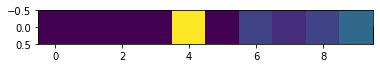

In [12]:
### net visualization
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import math


extent = 0, 28, 0, 28

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(10,10))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest")
        
def plotAttention(units):
    b, px, rest = units.shape
    print(np.amax(units), np.amin(units))
#     plt.figure(1, figsize=(20,20))
    h = w = int(math.sqrt(px))
    print(h, w)
    units = np.reshape(units, (h, w))
    plt.imshow(units, interpolation="nearest", cmap="viridis", alpha=0.5, extent=extent)

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={X:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotAttention(units)

    
fig = plt.figure(frameon=True)

imageToUse = mnist.test.images[np.random.randint(low=0, high=len(mnist.test.images))]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray", extent=extent)

layer = tf.get_default_graph().get_tensor_by_name('lastrelu:0') 
print(layer)


units = sess.run(layer,feed_dict={X:np.reshape(imageToUse,[1,784],order='F'),keep_prob:1.0})
print(units)
plt.imshow(units)

# getActivations(conv1w, imageToUse)

plt.show()


In [11]:
dir(tf
   )


['AUTO_REUSE',
 'AggregationMethod',
 'Assert',
 'AttrValue',
 'COMPILER_VERSION',
 'CXX11_ABI_FLAG',
 'ConditionalAccumulator',
 'ConditionalAccumulatorBase',
 'ConfigProto',
 'DType',
 'DeviceSpec',
 'Dimension',
 'Event',
 'FIFOQueue',
 'FixedLenFeature',
 'FixedLenSequenceFeature',
 'FixedLengthRecordReader',
 'GIT_VERSION',
 'GPUOptions',
 'GRAPH_DEF_VERSION',
 'GRAPH_DEF_VERSION_MIN_CONSUMER',
 'GRAPH_DEF_VERSION_MIN_PRODUCER',
 'GradientTape',
 'Graph',
 'GraphDef',
 'GraphKeys',
 'GraphOptions',
 'HistogramProto',
 'IdentityReader',
 'IndexedSlices',
 'InteractiveSession',
 'LMDBReader',
 'LogMessage',
 'MONOLITHIC_BUILD',
 'MetaGraphDef',
 'NameAttrList',
 'NoGradient',
 'NodeDef',
 'NotDifferentiable',
 'OpError',
 'Operation',
 'OptimizerOptions',
 'PaddingFIFOQueue',
 'Print',
 'PriorityQueue',
 'QUANTIZED_DTYPES',
 'QueueBase',
 'RaggedTensor',
 'RandomShuffleQueue',
 'ReaderBase',
 'RegisterGradient',
 'RunMetadata',
 'RunOptions',
 'Session',
 'SessionLog',
 'SparseCondi